# CNN & Computer Vision with TensorFlow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such visual data can be images, videos, or even live streams. In this notebook, we'll explore how to use convolutional neural networks to perform computer vision tasks.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import cv2
import pathlib
import random
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation
from tensorflow.keras.optimizers import Adam


## Get the Data

The images we are working with are from the [Food101](https://www.kaggle.com/datasets/dansbecker/food-101) dataset (101 different classes of food). However, we're going to simplify things and only use two classes:
1. Pizza
2. Steak

In [2]:
# Download zip file of pizza_steak images
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the downloaded file
#zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
#zip_ref.extractall()
#zip_ref.close()

## Inspect the data

In [3]:
!ls pizza_steak

test  train


In [4]:
!ls pizza_steak/train/steak

1000205.jpg 1647351.jpg 2238681.jpg 2824680.jpg 3375959.jpg 417368.jpg
100135.jpg  1650002.jpg 2238802.jpg 2825100.jpg 3381560.jpg 4176.jpg
101312.jpg  165639.jpg  2254705.jpg 2826987.jpg 3382936.jpg 42125.jpg
1021458.jpg 1658186.jpg 225990.jpg  2832499.jpg 3386119.jpg 421476.jpg
1032846.jpg 1658443.jpg 2260231.jpg 2832960.jpg 3388717.jpg 421561.jpg
10380.jpg   165964.jpg  2268692.jpg 285045.jpg  3389138.jpg 438871.jpg
1049459.jpg 167069.jpg  2271133.jpg 285147.jpg  3393547.jpg 43924.jpg
1053665.jpg 1675632.jpg 227576.jpg  2855315.jpg 3393688.jpg 440188.jpg
1068516.jpg 1678108.jpg 2283057.jpg 2856066.jpg 3396589.jpg 442757.jpg
1068975.jpg 168006.jpg  2286639.jpg 2859933.jpg 339891.jpg  443210.jpg
1081258.jpg 1682496.jpg 2287136.jpg 286219.jpg  3417789.jpg 444064.jpg
1090122.jpg 1684438.jpg 2291292.jpg 2862562.jpg 3425047.jpg 444709.jpg
1093966.jpg 168775.jpg  229323.jpg  2865730.jpg 3434983.jpg 447557.jpg
1098844.jpg 1697339.jpg 2300534.jpg 2878151.jpg 3435358.jpg 461187.jpg
1100074.jp

In [5]:
for dirpath, dirnames, filenames in os.walk('pizza_steak'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in pizza_steak
There are 2 directories and 0 images in pizza_steak/test
There are 0 directories and 250 images in pizza_steak/test/steak
There are 0 directories and 250 images in pizza_steak/test/pizza
There are 2 directories and 0 images in pizza_steak/train
There are 0 directories and 750 images in pizza_steak/train/steak
There are 0 directories and 750 images in pizza_steak/train/pizza


In [6]:
len(os.listdir("pizza_steak/train/pizza"))

750

In [7]:
len(os.listdir("pizza_steak/train/steak"))

750

In [8]:
# Get the classnames programatically
data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['pizza' 'steak']


In [9]:
# Visualize the data
def view_random_image(target_dir, target_class):
    # Setup the target directory 
    target_folder = target_dir+target_class
    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    plt.show()
    
    print(f"Image shape: {img.shape}")
    return img

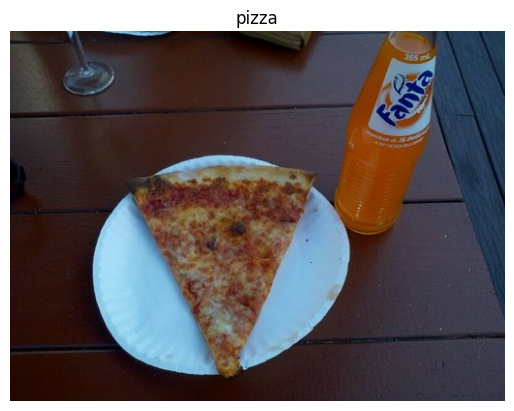

Image shape: (383, 512, 3)


In [10]:
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="pizza")

In [11]:
img

array([[[70, 63, 55],
        [60, 53, 45],
        [55, 51, 42],
        ...,
        [32, 58, 81],
        [32, 58, 81],
        [33, 59, 82]],

       [[72, 65, 57],
        [64, 57, 49],
        [60, 56, 47],
        ...,
        [32, 58, 81],
        [32, 58, 81],
        [32, 58, 81]],

       [[68, 61, 51],
        [64, 57, 47],
        [61, 57, 46],
        ...,
        [33, 59, 82],
        [32, 58, 81],
        [31, 57, 80]],

       ...,

       [[34,  7,  0],
        [35,  8,  1],
        [34,  7,  0],
        ...,
        [51, 53, 68],
        [51, 53, 68],
        [50, 52, 67]],

       [[33,  6,  0],
        [34,  7,  0],
        [33,  6,  0],
        ...,
        [52, 54, 69],
        [53, 55, 70],
        [53, 55, 70]],

       [[33,  6,  0],
        [34,  7,  0],
        [34,  7,  0],
        ...,
        [53, 55, 70],
        [54, 56, 71],
        [54, 56, 71]]], dtype=uint8)

In [12]:
img.shape

(383, 512, 3)

**Note**: Many `ML` models, including `Neural Networks` prefer the values to be between 0 & 1. This is called `Normalization`. We can normalize the image by dividing each pixel value by 255. We can do this by defining a `Normalization` layer in the `CNN` model.

In [13]:
img/255.

array([[[0.2745098 , 0.24705882, 0.21568627],
        [0.23529412, 0.20784314, 0.17647059],
        [0.21568627, 0.2       , 0.16470588],
        ...,
        [0.1254902 , 0.22745098, 0.31764706],
        [0.1254902 , 0.22745098, 0.31764706],
        [0.12941176, 0.23137255, 0.32156863]],

       [[0.28235294, 0.25490196, 0.22352941],
        [0.25098039, 0.22352941, 0.19215686],
        [0.23529412, 0.21960784, 0.18431373],
        ...,
        [0.1254902 , 0.22745098, 0.31764706],
        [0.1254902 , 0.22745098, 0.31764706],
        [0.1254902 , 0.22745098, 0.31764706]],

       [[0.26666667, 0.23921569, 0.2       ],
        [0.25098039, 0.22352941, 0.18431373],
        [0.23921569, 0.22352941, 0.18039216],
        ...,
        [0.12941176, 0.23137255, 0.32156863],
        [0.1254902 , 0.22745098, 0.31764706],
        [0.12156863, 0.22352941, 0.31372549]],

       ...,

       [[0.13333333, 0.02745098, 0.        ],
        [0.1372549 , 0.03137255, 0.00392157],
        [0.13333333, 0

## An end-to-end example of a CNN for computer vision

* Load the images
* Preprocess the images
* Build a CNN model
* Compile the model
* Fit the model
* Evaluate the model

In [14]:
tf.random.set_seed(42)

# Preprocess the data (get all of the pixel values between 0 and 1, as normalizing/standardizing/scaling does)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

#Import data and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time (default=32)
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed = 42
)
valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed = 42
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [15]:
# Build a CNN model 
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3, # can also be (3, 3)
                           activation="relu",
                           input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                              padding="valid"), # padding can also be "same"
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output for binary classification
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data, 
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data)
                        )

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



Epoch 1/10


2023-08-05 15:10:10.705911: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


47/47 [==============================] - 6s 106ms/step - loss: 0.6113 - accuracy: 0.6533 - val_loss: 0.4330 - val_accuracy: 0.8380
Epoch 2/10
47/47 [==============================] - 5s 103ms/step - loss: 0.4710 - accuracy: 0.7700 - val_loss: 0.3918 - val_accuracy: 0.8360
Epoch 3/10
47/47 [==============================] - 5s 104ms/step - loss: 0.4324 - accuracy: 0.8073 - val_loss: 0.3943 - val_accuracy: 0.8280
Epoch 4/10
47/47 [==============================] - 5s 99ms/step - loss: 0.3638 - accuracy: 0.8480 - val_loss: 0.3679 - val_accuracy: 0.8560
Epoch 5/10
47/47 [==============================] - 5s 114ms/step - loss: 0.3109 - accuracy: 0.8673 - val_loss: 0.3835 - val_accuracy: 0.8400
Epoch 6/10
47/47 [==============================] - 5s 98ms/step - loss: 0.2292 - accuracy: 0.9267 - val_loss: 0.3876 - val_accuracy: 0.8400
Epoch 7/10
47/47 [==============================] - 4s 89ms/step - loss: 0.1801 - accuracy: 0.9353 - val_loss: 0.4702 - val_accuracy: 0.8020
Epoch 8/10
47/47 [==

In [16]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

## Binary Classification: Breaking it down

1. Check the data
2. Preprocess the data (prepare it for the model, scaling/normalization)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different hyperparameters to improve the model
7. Repeat until satisfied

### 1. Check out the data

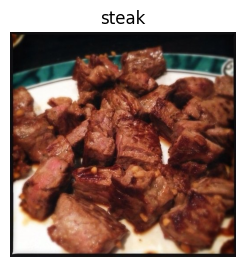

Image shape: (512, 512, 3)


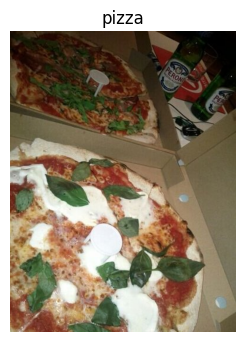

Image shape: (512, 384, 3)


In [17]:
# Visualize data
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1,2,2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")


### Preprocess the data

In [18]:
# Define directory dataset path
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

# Create train and test data generators and rescale the data
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Turn data into batches(A batch is a small subset of data, rather than looking at the entire dataset at once, the model only looks at 
# one batch(32 in this case) at a time)
train_data = train_datagen.flow_from_directory(directory=train_dir, # target directory
                                               target_size=(224, 224), # target size
                                               class_mode="binary", # type of problem
                                               batch_size=32 # size of batches
)
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode="binary",
                                             batch_size=32
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [19]:
images, labels = train_data.next() # get the next batch of images/labels
len(images), len(labels)

(32, 32)

In [20]:
# Get the first 2 images
images[:2], images[0].shape

(array([[[[0.7254902 , 0.69411767, 0.6431373 ],
          [0.70980394, 0.6784314 , 0.627451  ],
          [0.6       , 0.5686275 , 0.5176471 ],
          ...,
          [0.22352943, 0.12156864, 0.07058824],
          [0.1764706 , 0.10196079, 0.07450981],
          [0.14117648, 0.08627451, 0.07450981]],
 
         [[0.7254902 , 0.69411767, 0.6431373 ],
          [0.69411767, 0.6627451 , 0.6117647 ],
          [0.5921569 , 0.56078434, 0.5176471 ],
          ...,
          [0.18823531, 0.09803922, 0.04313726],
          [0.17254902, 0.09803922, 0.07058824],
          [0.15294118, 0.09411766, 0.07450981]],
 
         [[0.7294118 , 0.69803923, 0.654902  ],
          [0.7058824 , 0.6745098 , 0.6313726 ],
          [0.6627451 , 0.6313726 , 0.5882353 ],
          ...,
          [0.16862746, 0.08235294, 0.03921569],
          [0.1764706 , 0.10196079, 0.07450981],
          [0.16078432, 0.09411766, 0.06666667]],
 
         ...,
 
         [[0.21568629, 0.10980393, 0.07450981],
          [0.20000

### 3. Build the Model

> **Note:** In deep learning, there is almost an infinite amount of architectures one could create. So one of the best ways to get started is to start with something simple and see if it works on the data. Then introduce complexity as needed.

In [21]:
# Starting with a baseline CNN model(A baseline model is a simple model that you compare your model's performance to)
model_2 = Sequential([
    Conv2D(filters=10, # the no of sliding windows going across an input(higher = more patterns learned)
           kernel_size=3, # size of the sliding window that moves across the image
           strides=1, # how much the sliding window moves across the image by
           padding='valid', # padding='same' means output shape is same as input shape, padding='valid' means output shape is smaller than input shape
           activation='relu', 
           input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [22]:
# Compile the model
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# Summary of the model
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_1 (Flatten)         (None, 475240)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


### 4. Fit the model

In [24]:
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data)
                        )

Epoch 1/5
47/47 [==============================] - 6s 109ms/step - loss: 1.2225 - accuracy: 0.5273 - val_loss: 0.6664 - val_accuracy: 0.5580
Epoch 2/5
47/47 [==============================] - 5s 102ms/step - loss: 0.5341 - accuracy: 0.7413 - val_loss: 0.4221 - val_accuracy: 0.8140
Epoch 3/5
47/47 [==============================] - 5s 95ms/step - loss: 0.3169 - accuracy: 0.8713 - val_loss: 0.4327 - val_accuracy: 0.8200
Epoch 4/5
47/47 [==============================] - 4s 93ms/step - loss: 0.2065 - accuracy: 0.9407 - val_loss: 0.4812 - val_accuracy: 0.7640
Epoch 5/5
47/47 [==============================] - 4s 93ms/step - loss: 0.0788 - accuracy: 0.9800 - val_loss: 0.4708 - val_accuracy: 0.8180


### 5. Evaluating the Model

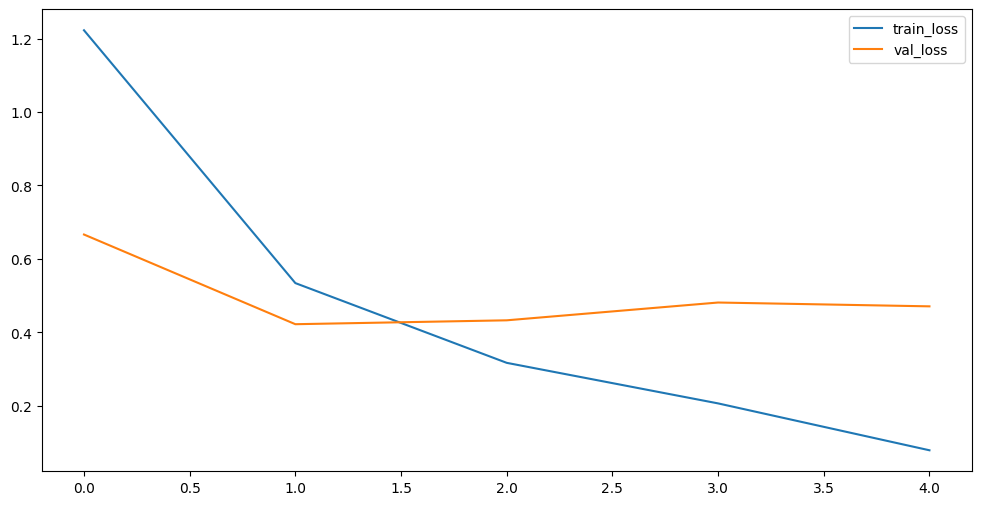

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(history_2.history['loss'], label='train_loss')
plt.plot(history_2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

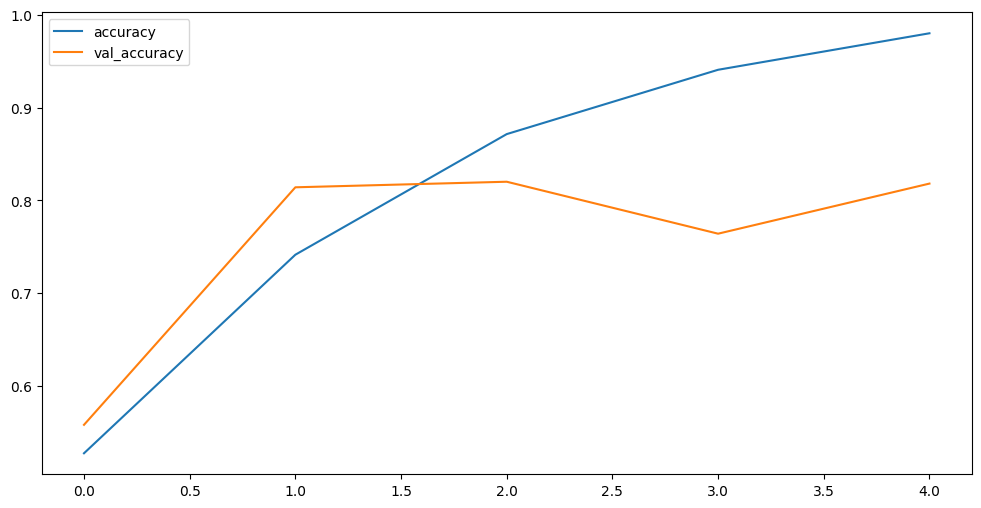

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(history_2.history['accuracy'], label='accuracy')
plt.plot(history_2.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

The **Validation_loss** is increasing which indicates that the model is **Overfitting** the training data.

In [27]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_1 (Flatten)         (None, 475240)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


### 6. Adjust the Model Parameters

Fitting a ML model comes in 3 steps:
0. Create the baseline model
1. Beat the baseline by overfitting a larger model
2. Reducte overfitting by adding regularization and dropout layers

Ways to induce overfitting:
- Increase the number of layers
- Increase the number of neurons
- Add another dense layer to the output of the flatten layer

Reduce overfitting:
* Add data Augmentation
* Add regularization layers(MaxPool2D, Dropout)
* Add more data

In [28]:
# Baseline Model
model_3 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

In [29]:
# Compile the model
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data)
                        )

Epoch 1/5
47/47 [==============================] - 5s 88ms/step - loss: 0.6191 - accuracy: 0.6600 - val_loss: 0.4834 - val_accuracy: 0.8380
Epoch 2/5
47/47 [==============================] - 4s 81ms/step - loss: 0.4822 - accuracy: 0.7707 - val_loss: 0.3907 - val_accuracy: 0.8540
Epoch 3/5
47/47 [==============================] - 4s 81ms/step - loss: 0.4338 - accuracy: 0.8013 - val_loss: 0.4131 - val_accuracy: 0.8540
Epoch 4/5
47/47 [==============================] - 4s 82ms/step - loss: 0.4157 - accuracy: 0.8200 - val_loss: 0.3975 - val_accuracy: 0.8240
Epoch 5/5
47/47 [==============================] - 4s 84ms/step - loss: 0.3771 - accuracy: 0.8387 - val_loss: 0.3349 - val_accuracy: 0.8620


In [31]:
# Check out the model architecture
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

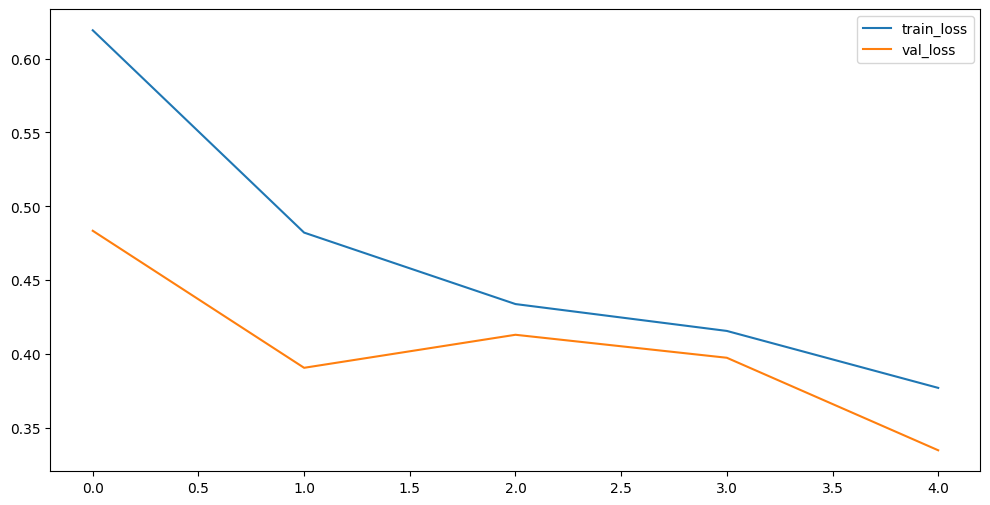

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(history_3.history['loss'], label='train_loss')
plt.plot(history_3.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

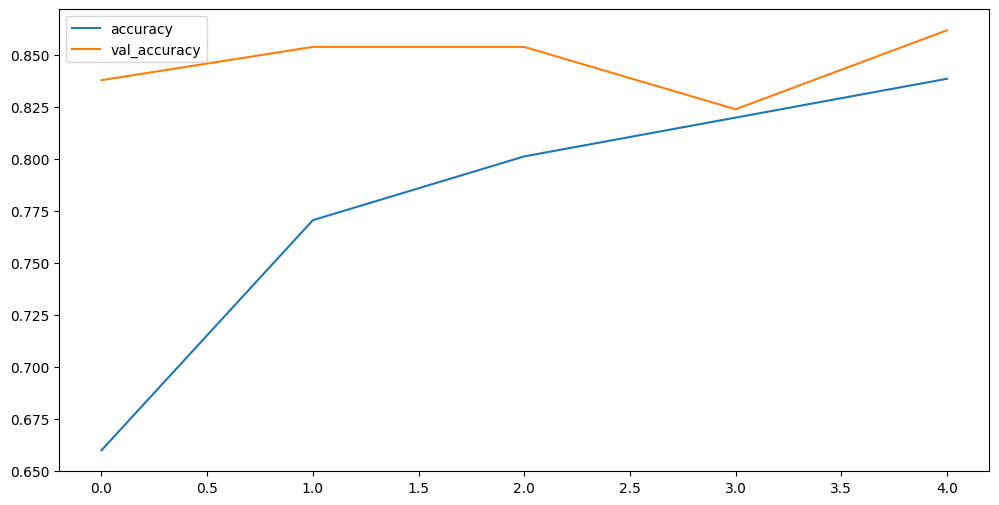

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(history_3.history['accuracy'], label='accuracy')
plt.plot(history_3.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

Nice! We can see the training curves get a lot closer to eachother. However, our the validation loss looks to start increasing towards the end and in turn potentially leading to overfitting.

#### Data Augmentation

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar. Data Augmentation is only applied to the training data, not the validation or test data.

In [34]:
# Create ImageDataGenerator training instance
train_datagen_augmented = ImageDataGenerator(rescale=1./255,
                                             rotation_range=0.2, # how much to rotate images by
                                             shear_range=0.2, # how much to shear images by
                                             zoom_range=0.2, # zoom in randomly on images
                                             width_shift_range=0.2, # randomly shift images horizontally
                                             height_shift_range=0.2, # randomly shift images vertically
                                             horizontal_flip=True # randomly flip images horizontally
)
# Create ImageDataGenerator non-augmented instance
train_datagen = ImageDataGenerator(rescale=1./255)

# Create ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

In [35]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False
) 

# Create non-augmented train data batches
print()
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False
) 
# Create non-augmented test data batches
print()
print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary'
)

Augmented training images:
Found 1500 images belonging to 2 classes.



Non-augmented training images:
Found 1500 images belonging to 2 classes.

Unchanged test images:
Found 500 images belonging to 2 classes.


In [36]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

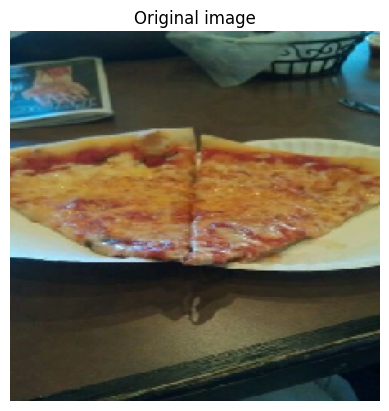

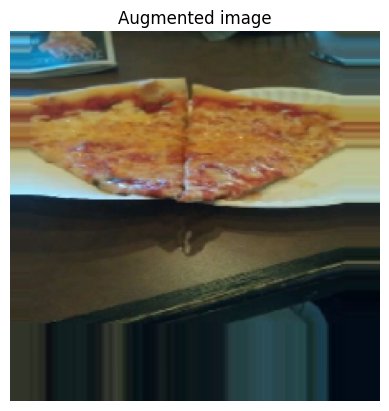

In [37]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

After going through a sample of original and augmented images, you can start to see some of the example transformations on the training images.

Notice how some of the augmented images look like slightly warped versions of the original image. This means our model will be forced to try and learn patterns in less-than-perfect images, which is often the case when using real-world images.

In [38]:
# Building our Model
tf.random.set_seed(42)

# 1. Create the model
model_4 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

# Compile the model
model_4.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

# Fit the model
history_4 = model_4.fit(train_data_augmented,
                        epochs=10,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
47/47 [==============================] - 10s 208ms/step - loss: 0.7286 - accuracy: 0.4633 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 2/10
47/47 [==============================] - 10s 220ms/step - loss: 0.6921 - accuracy: 0.4993 - val_loss: 0.6877 - val_accuracy: 0.5000
Epoch 3/10
47/47 [==============================] - 10s 209ms/step - loss: 0.6874 - accuracy: 0.5680 - val_loss: 0.6674 - val_accuracy: 0.6160
Epoch 4/10
47/47 [==============================] - 10s 212ms/step - loss: 0.6979 - accuracy: 0.6027 - val_loss: 1.3429 - val_accuracy: 0.5000
Epoch 5/10
47/47 [==============================] - 22s 480ms/step - loss: 0.6623 - accuracy: 0.6267 - val_loss: 0.6237 - val_accuracy: 0.7740
Epoch 6/10
47/47 [==============================] - 18s 378ms/step - loss: 0.6380 - accuracy: 0.6720 - val_loss: 0.6104 - val_accuracy: 0.6280
Epoch 7/10
47/47 [==============================] - 17s 357ms/step - loss: 0.6411 - accuracy: 0.6440 - val_loss: 0.5116 - val_accuracy: 0.8080

The **Model** performance is quite low cause when we created `train_data_augmented` we turned off data shuffling using `shuffle=False` which means our model only sees a batch of a single kind of images at a time.

In [39]:
# Import data and augment it
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True)

Found 1500 images belonging to 2 classes.


In [40]:
# Building our Model
tf.random.set_seed(42)

# 1. Create the model
model_5 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

# Compile the model
model_5.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

# Fit the model
history_5 = model_5.fit(train_data_augmented_shuffled,
                        epochs=10,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
47/47 [==============================] - 20s 401ms/step - loss: 0.6213 - accuracy: 0.6480 - val_loss: 0.4895 - val_accuracy: 0.7580
Epoch 2/10
47/47 [==============================] - 18s 371ms/step - loss: 0.5507 - accuracy: 0.7247 - val_loss: 0.4237 - val_accuracy: 0.8100
Epoch 3/10
47/47 [==============================] - 18s 370ms/step - loss: 0.4842 - accuracy: 0.7700 - val_loss: 0.3526 - val_accuracy: 0.8340
Epoch 4/10
47/47 [==============================] - 17s 363ms/step - loss: 0.4796 - accuracy: 0.7793 - val_loss: 0.3939 - val_accuracy: 0.8160
Epoch 5/10
47/47 [==============================] - 16s 345ms/step - loss: 0.4579 - accuracy: 0.7787 - val_loss: 0.4899 - val_accuracy: 0.7540
Epoch 6/10
47/47 [==============================] - 17s 355ms/step - loss: 0.4702 - accuracy: 0.7707 - val_loss: 0.3444 - val_accuracy: 0.8480
Epoch 7/10
47/47 [==============================] - 17s 353ms/step - loss: 0.4485 - accuracy: 0.7960 - val_loss: 0.3635 - val_accuracy: 0.8380

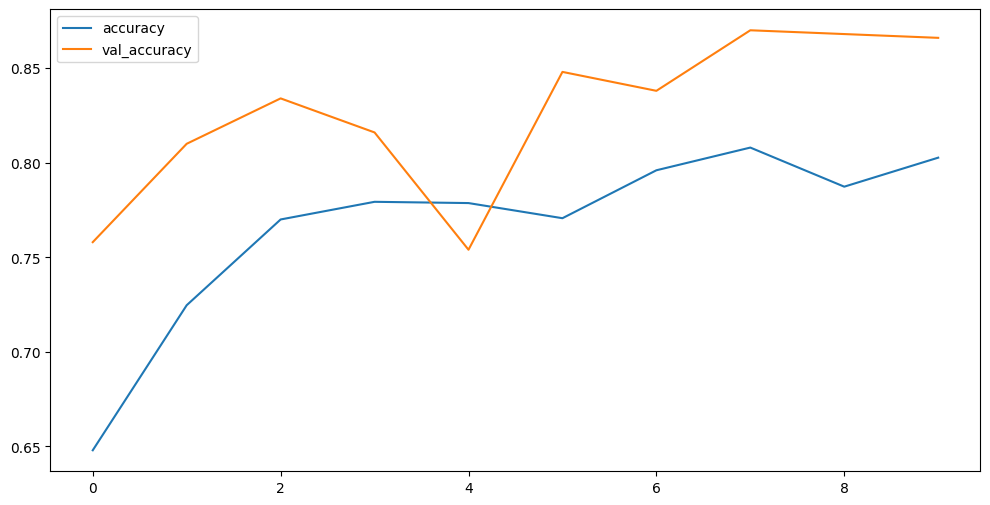

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(history_5.history['accuracy'], label='accuracy')
plt.plot(history_5.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

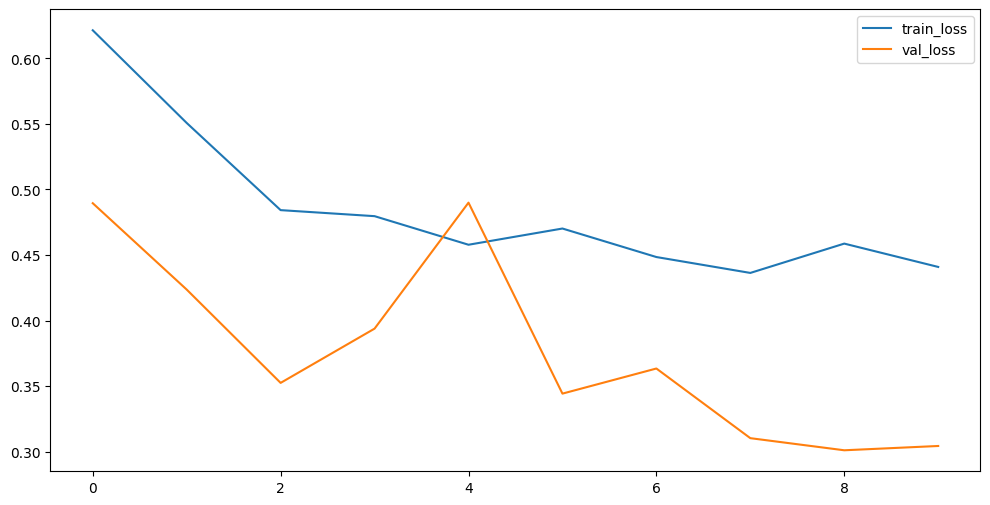

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(history_5.history['loss'], label='train_loss')
plt.plot(history_5.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### 7. Improve the model until satisfied with the results

Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:

1. Increase the number of model layers (e.g. add more convolutional layers).
2. Increase the number of filters in each convolutional layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).
3. Train for longer (more epochs).
4. Finding an ideal learning rate.
5. Get more data (give the model more opportunities to learn).
6. Use **transfer learning** to leverage what another image model has learned and adjust it for our own use case.

#### 1. Increasing the model layers

In [43]:
# Build the model
model_6 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_6 = model_6.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 36s 733ms/step - loss: 0.6606 - accuracy: 0.5920 - val_loss: 0.5166 - val_accuracy: 0.7940
Epoch 2/5
47/47 [==============================] - 26s 560ms/step - loss: 0.5243 - accuracy: 0.7460 - val_loss: 0.4015 - val_accuracy: 0.8380
Epoch 3/5
47/47 [==============================] - 21s 452ms/step - loss: 0.4959 - accuracy: 0.7567 - val_loss: 0.3649 - val_accuracy: 0.8300
Epoch 4/5
47/47 [==============================] - 20s 415ms/step - loss: 0.4631 - accuracy: 0.7840 - val_loss: 0.3315 - val_accuracy: 0.8580
Epoch 5/5
47/47 [==============================] - 22s 463ms/step - loss: 0.4557 - accuracy: 0.7887 - val_loss: 0.3403 - val_accuracy: 0.8720


In [44]:
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_17 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_19 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                 

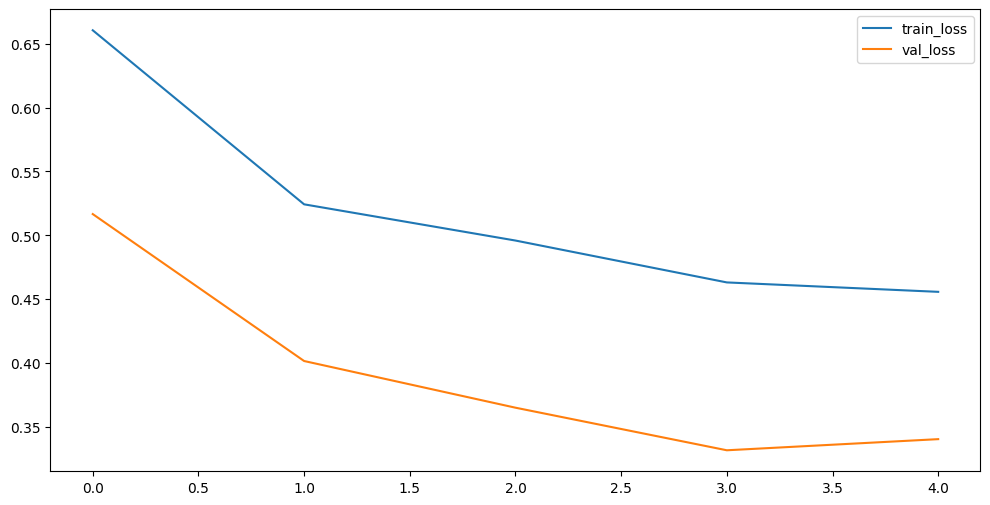

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(history_6.history['loss'], label='train_loss')
plt.plot(history_6.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

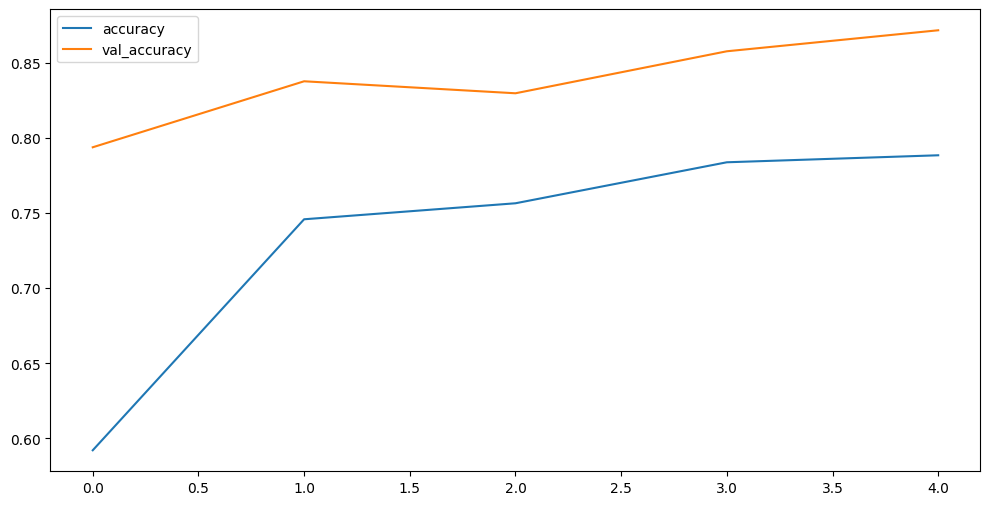

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(history_6.history['accuracy'], label='accuracy')
plt.plot(history_6.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [47]:
model_4.evaluate(test_data)

16/16 [==============================] - 2s 103ms/step - loss: 0.4836 - accuracy: 0.7780


[0.4835820198059082, 0.777999997138977]

In [48]:
model_5.evaluate(test_data)

16/16 [==============================] - 2s 153ms/step - loss: 0.3045 - accuracy: 0.8660


[0.3044569492340088, 0.8659999966621399]

In [49]:
model_6.evaluate(test_data)

16/16 [==============================] - 3s 157ms/step - loss: 0.3403 - accuracy: 0.8720


[0.34025755524635315, 0.871999979019165]

### Making a prediction with our trained model

In [50]:
# Classes we are working with
print(class_names)

['pizza' 'steak']


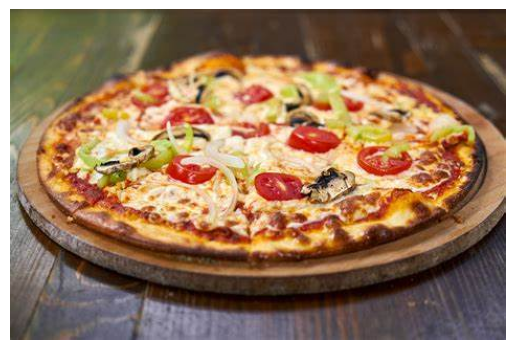

In [51]:
# View the sample images
steak = mpimg.imread('Test_data/OIP (1).jpeg')
plt.imshow(steak)
plt.axis(False);

In [52]:
# Check the shape of the image
steak.shape

(316, 474, 3)

Since our model takes in images of shapes `(224, 224, 3)`, we've got to reshape our custom image to use it with our model.

To do so, we can import and decode our image using `tf.io.read_file` (for readining files) and `tf.image` (for resizing our image and turning it into a tensor).

In [53]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img, channels=3)
  # Resize the image  
  img = tf.image.resize(img, [img_shape, img_shape])
  # Scale the image (get all values between 0 and 1)
  if scale:
    return img/255.
  else:
    return img

In [67]:
# Load in and preprocess the data
pizza = load_and_prep_image('Test_data/OIP (1).jpeg')
pizza

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3192577 , 0.34278712, 0.20071185],
        [0.32710084, 0.34278712, 0.20444646],
        [0.3310224 , 0.34734502, 0.20033795],
        ...,
        [0.20311625, 0.13644958, 0.10473906],
        [0.20311625, 0.13644958, 0.10455212],
        [0.20311625, 0.13644958, 0.10436515]],

       [[0.33515406, 0.36003166, 0.20829833],
        [0.34220985, 0.35952476, 0.21052217],
        [0.3445028 , 0.3637947 , 0.20597066],
        ...,
        [0.19758403, 0.13142432, 0.09306709],
        [0.19758403, 0.13170473, 0.09215683],
        [0.19758403, 0.13198519, 0.09124632]],

       [[0.35325631, 0.3807073 , 0.21579131],
        [0.36109945, 0.38081232, 0.21957126],
        [0.36499897, 0.3877276 , 0.21720485],
        ...,
        [0.20836835, 0.14562324, 0.09280902],
        [0.20836835, 0.14562324, 0.09191095],
        [0.20836835, 0.14562324, 0.09101264]],

       ...,

       [[0.2291737 , 0.22896354, 0.18179965],
        [0.24

In [68]:
# Make a prediction on the custom image
model_6.predict(pizza)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_5/conv2d_16/Conv2D' defined at (most recent call last):
    File "/Users/oabas/miniconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/oabas/miniconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/oabas/miniconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/oabas/miniconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/oabas/miniconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/0c/_mtbsk_x4238bbw22x165tlm0000gn/T/ipykernel_88348/3508041815.py", line 2, in <module>
      model_6.predict(pizza)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
      return self(x, training=False)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_5/conv2d_16/Conv2D'
input must be 4-dimensional[32,224,3]
	 [[{{node sequential_5/conv2d_16/Conv2D}}]] [Op:__inference_predict_function_20475]

**Note:** When one train a neural network, and we want to test the model on a custom data, it's important that the custom data is in the same format as the training data. For example, if the training data is a 4D array, then the custom data must also be a 4D array. If the training data is a 2D array, then the custom data must also be a 2D array. If the training data is a 1D array, then the custom data must also be a 1D array. If the training data is a scalar, then the custom data must also be a scalar.

In [71]:
# Add an extra axis
print(f"Before: {pizza.shape}")
pizza = tf.expand_dims(pizza, axis=0)
print(f"After: {pizza.shape}")

Before: (224, 224, 3)
After: (1, 224, 224, 3)


In [72]:
# Make a prediction on custom image tensor
pred = model_6.predict(pizza)
pred

1/1 [==============================] - 0s 64ms/step


array([[0.08303415]], dtype=float32)

In [73]:
# Indexing the predicted class by roundong the predicted probability of each class
pred_class = class_names[int(tf.round(pred))]
pred_class

'pizza'

In [74]:
def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[int(tf.round(pred))]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    plt.show()

1/1 [==============================] - 0s 26ms/step


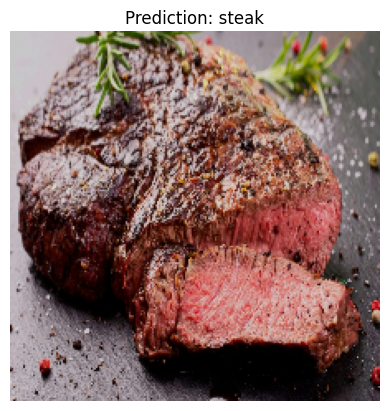

In [75]:
# Test our model on a custom image
pred_and_plot(model_6, "Test_data/R.jpeg", class_names)

1/1 [==============================] - 0s 21ms/step


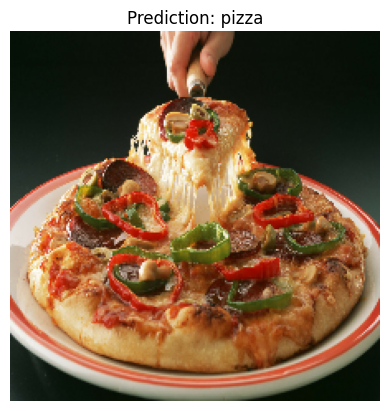

In [76]:
# Test our model on a custom image
pred_and_plot(model_6, "Test_data/R (1).jpeg", class_names)

1/1 [==============================] - 0s 16ms/step


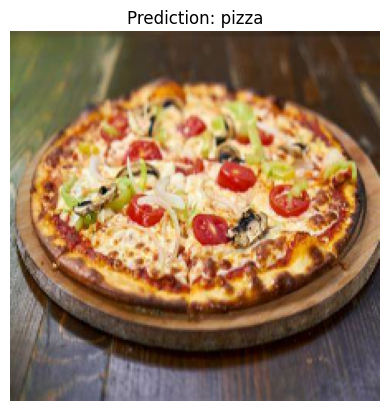

In [77]:
# Test our model on a custom image
pred_and_plot(model_6, "Test_data/OIP (1).jpeg", class_names)

## Multi-class Classification

### Import Data

In [78]:
# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-08-06 09:39:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.169.16, 172.217.169.48, 142.250.178.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.169.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  13.3MB/s    in 40s     

2023-08-06 09:39:55 (12.4 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [4]:
# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("data/10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'data/10_food_classes_all_data'.
There are 10 directories and 0 images in 'data/10_food_classes_all_data/test'.
There are 0 directories and 250 images in 'data/10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in 'data/10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in 'data/10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in 'data/10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in 'data/10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in 'data/10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in 'data/10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in 'data/10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in 'data/10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in